# Heat Conduction Equation Implementation

We know that heat conduction equation has a form:

$$ k \left[ \frac{\partial^2 T(x,y,t)}{\partial x^2} + \frac{\partial^2 T(x,y,t)}{\partial y^2} \right] = \rho c \frac{\partial T(x,y,t)}{\partial t}
$$

Where each term is defined
- $T \left(x,y,t \right)$: Temperature at point $\left(x,y \right)$ and time $t$
- $\frac{\partial^2 T \left(x,y,t \right)}{\partial x^2}$: Second partial derivative of temperature with respect to $x$. It represents the rate of change of the temperature gradient in the $x$-direction
-  $\frac{\partial^2 T \left(x,y,t \right)}{\partial y^2}$: Second partial derivative of temperature with respect to $y$. It represents the rate of change of the temperature gradient in the $y$-direction.
-  $\frac{\partial T \left(x,y,t \right)}{\partial t}$: First partial derivative of temperature with respect to $t$. It represents the rate of change of temperature over time.
- $k$: Thermal conductivity of the material. It measures the ability of the material to conduct heat.
- $\rho$: Density of the material. It represents the mass per unit volume of the material.
- $c$: Specific heat capacity of the material. It measures the amount of heat required to change the temperature of a unit mass of the material by one degree.

## Usage for Image

If we define image as a grid of pixels then we can say that each pixel will have a temperature value $T \left(x,y,t \right)$.


## Optical Flow
In our last part we defined `optical_flow.ipynb` which takes a video and creates a `.npy` type of file with optical flows of the video.

The main question is how can we use it here?

If we define a new variable $Q = \sqrt{v_x^2 + v_y^2}$ it will represent the magnitude of optical flow.

Now lets add this term to our conduction equation:

$$ k \left[ \frac{\partial^2 T(x,y,t)}{\partial x^2} + \frac{\partial^2 T(x,y,t)}{\partial y^2} \right] = \rho c \frac{\partial T(x,y,t)}{\partial t} + Q$$

Python Libraries

In [116]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

At first lets define image path.

In [117]:
IMAGE_PATH = 'cloud.jpg'

Now we define the path of optical flow generated by `optical_flow.ipynb`

In [118]:
OPTICAL_PATH = '../optical_flow/waterfall.npy'

Path to save images

In [119]:
SAVE_IMAGE_PATH = 'images/'

Path to save video

In [120]:
SAVE_VIDEO_PATH = 'heat_equation.avi'

Read the image to get our starting frame

In [121]:
image = cv2.imread(IMAGE_PATH)

Display Image

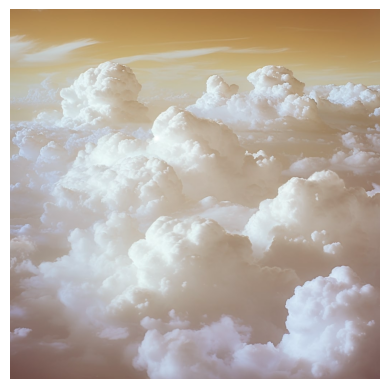

In [122]:
plt.imshow(image)
plt.axis('off')
plt.show()

Now we get image dimenssions to use it in future to resize optical flows

In [123]:
height, width, channels = image.shape

print(f'Height: {height}', f'width: {width}', f'channels: {channels}')

Height: 1024 width: 1024 channels: 3


The next step is to get optical flow list and save it in variable

In [124]:
optical_flows = np.load(OPTICAL_PATH)

print(optical_flows)

[[[[-1.52322401e-15 -5.22021323e-16]
   [ 7.89227350e-09  9.86987506e-11]
   [ 3.29146104e-07  1.46109054e-08]
   ...
   [-8.96894126e-05  1.54424706e-04]
   [-1.40564762e-05  8.81640517e-05]
   [ 7.43044211e-06  8.28060292e-05]]

  [[-6.01185827e-15  7.07831394e-16]
   [ 9.37717015e-09  9.68126482e-11]
   [ 4.03760254e-07  1.28785036e-08]
   ...
   [-1.16973330e-04  1.71267151e-04]
   [-2.07968678e-05  8.90065421e-05]
   [ 4.41723523e-06  8.71942320e-05]]

  [[ 1.61293526e-12  4.67213108e-14]
   [ 8.00894195e-09 -2.22578640e-11]
   [ 3.91976243e-07 -1.80717041e-08]
   ...
   [-2.00633003e-04  4.15096758e-04]
   [-3.65680025e-05  2.29872996e-04]
   [-1.17236191e-07  2.68312229e-04]]

  ...

  [[-2.94482863e-14  5.18673612e-14]
   [-5.19180273e-14  2.18906409e-13]
   [ 1.36681957e-10 -1.92626401e-11]
   ...
   [-1.11951493e-03  1.74739715e-02]
   [-1.38687668e-03  5.74378204e-03]
   [-9.35858057e-04  3.00030294e-03]]

  [[-2.09053237e-14  3.32078555e-14]
   [-1.59796018e-14  2.27135900e

Now lets create list to save our images

In [125]:
images = []

Define the constant variables

- `rho` -> Density
- `c` -> Specific heat
- `dx` -> Step size in x-direction
- `dy` -> Step size in y-direction
- `dt` -> Time step size
- `num_steps` -> Number of time steps
- `k` -> Thermal conductivity of the material. It measures the ability of the material to conduct heat.
- `beta` -> Scaling factor for the advection term

In [126]:
rho = 1.0
c = 1.0
dx = 1.0
dy = 1.0
dt = 0.1
num_steps = 100
k = 1.0
beta = 0.1

Lets create a function how solving equation by explicit method

In [127]:
alpha = (k * dt) / (rho * c * (dx**2))

def solver(T, Q):
    T_next = np.zeros_like(T)

    for k in range(channels):
        T_channel = T[:, :, k]
        T_next_channel = T_channel.copy()

        diffusion_x = alpha * (np.roll(T_channel, -1, axis=0) - 2 * T_channel + np.roll(T_channel, 1, axis=0)) / dx**2
        diffusion_y = beta * (np.roll(T_channel, -1, axis=1) - 2 * T_channel + np.roll(T_channel, 1, axis=1)) / dy**2

        T_next_channel[1:-1, 1:-1] += diffusion_x[1:-1, 1:-1] + diffusion_y[1:-1, 1:-1] + Q[1:-1, 1:-1]

        T_next[:, :, k] = T_next_channel
        
    return T_next

Now we do for each optical flow

In [128]:
last_image_index = -1

for optical_flow in optical_flows:
    v_x_origin = optical_flow[:, :, 0]
    v_y_origin = optical_flow[:, :, 1]

    v_x = cv2.resize(v_x_origin, (width, height), interpolation=cv2.INTER_LINEAR)
    v_y = cv2.resize(v_y_origin, (width, height), interpolation=cv2.INTER_LINEAR)

    Q = np.sqrt(v_x**2 + v_y**2)

    if last_image_index == -1:
        T_0 = image.astype(float)
    else:
        T_0 = images[last_image_index].astype(float)
    
    T = solver(T_0, Q)
    T = np.clip(T, 0, 255)

    images.append(T)
    last_image_index += 1

    cv2.imwrite(f'{SAVE_IMAGE_PATH}{last_image_index}.png', np.array(T).astype(np.uint8))

Generate video

In [129]:
video_writer = cv2.VideoWriter(SAVE_VIDEO_PATH, cv2.VideoWriter_fourcc(*'MJPG'), 30, (width, height))

index = 0
for i in images:
    im = cv2.imread(f'{SAVE_IMAGE_PATH}{index}.png')
    video_writer.write(im)
    index+=1

## References

Hsu, Heng-Pin, et al. “An Analytic Solution for 2D Heat Conduction Problems with General Dirichlet Boundary Conditions.” Axioms, vol. 12, no. 5, 1 May 2023, p. 416, www.mdpi.com/2075-1680/12/5/416, https://doi.org/10.3390/axioms12050416.